## Network traversal model
In this notebook we will load the Janelia hemibrain connectome graph and use a probabalistic network traversal to sort neurons into layers with respect to the olfactory system.

This notebook is a slimmed-down version of what we used for the layer analyses in Schlegel, Bates et al. (2020). In particular, we are using raw hemibrain type annotations from neuPrint to compile groups of neurons which may differ slightly from the curations in the paper (e.g. for descending neurons).

### Dependencies
You will need the following dependencies which can be installed using `pip`:
1. [navis](https://navis.readthedocs.io/en/latest/): `pip3 install navis` 
2. [neuprint-python](https://github.com/connectome-neuprint/neuprint-python): `pip3 install neuprint-python`

In addition, you will need to have your neuPrint authorization token set as environmental variable. See neuprint-python's [docs](https://connectome-neuprint.github.io/neuprint-python/docs/)

In [59]:
import os

import navis
import navis.interfaces.neuprint as neu

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_color_codes('muted')

NC = neu.NeuronCriteria
client = neu.Client('https://neuprint.janelia.org', dataset='hemibrain:v1.1')

In [31]:
print('navis version:', navis.__version__)

navis version: 0.3.4


In [8]:
# First grab all neurons that have either pre- or postsynapses 
# (we don't really care about neurons without connectivity for this analysis)
all_meta1, roi1 = neu.fetch_neurons(NC(min_post=1))
all_meta2, roi2 = neu.fetch_neurons(NC(min_pre=1))

# Combine above dataframes
all_roi = pd.concat([roi1, roi2], axis=0).drop_duplicates(['bodyId', 'roi'])
meta = pd.concat([all_meta1, all_meta2], axis=0).drop_duplicates('bodyId')
meta.tail(2)

,bodyId,instance,type,pre,post,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,inputRois,outputRois,roiInfo
143355,7112622817,None,None,2,0,2231129,Assign,None,0.5assign,None,NaN,None,[],"[ATL(R), INP]","{'INP': {'pre': 2, 'downstream': 19}, 'ATL(R)'..."
143362,7112623243,None,None,2,0,682292,Assign,None,0.5assign,None,NaN,None,[],"[VLNP(R), WED(R)]","{'VLNP(R)': {'pre': 2, 'downstream': 9}, 'WED(..."


In [13]:
# Extract RNs
is_orn = meta.type.str.startswith('ORN_', na='').astype(bool)
is_trn = meta.type.str.startswith('TRN_', na='').astype(bool)
is_hrn = meta.type.str.startswith('HRN_', na='').astype(bool)

rns = meta[is_orn | is_trn | is_hrn]
rns.head(2)

,bodyId,instance,type,pre,post,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,inputRois,outputRois,roiInfo
70714,1543124896,ORN_DM3_L,ORN_DM3,77,97,85635827,Traced,True,Leaves,None,NaN,None,"[AL(L), AL(R), AL-DA3(L), AL-DC1(R), AL-DM1(L)...","[AL(L), AL(R), AL-DL5(R), AL-DM1(L), AL-DM3(L)...","{'AL(R)': {'pre': 55, 'post': 66, 'downstream'..."
70715,1543124950,ORN_DM3_L,ORN_DM3,72,109,70688772,Traced,True,Leaves,None,NaN,None,"[AL(L), AL(R), AL-DM1(L), AL-DM1(R), AL-DM3(L)...","[AL(L), AL(R), AL-DM1(L), AL-DM3(L), AL-DM3(R)]","{'AL(L)': {'pre': 36, 'post': 60, 'downstream'..."


In [16]:
# Now grab edges between neurons that:
# - either have a "type"...
# - ... or are labeled as "Roughly traced" or "Traced"
export_dir = '~/Downloads/adjacencies-test/'
has_type = ~meta['type'].isnull()
is_traced =  meta.statusLabel.isin(['Roughly traced', 'Traced'])
criteria = NC(bodyId=meta[has_type | is_traced].bodyId)

# This fetches the actual edges and stores them in the export directory
_, edges = neu.fetch_adjacencies(criteria, criteria, include_nonprimary=False, export_dir=export_dir, batch_size=200)

# This is in case you already downloaded them
#edges = pd.read_csv(f'{os.path.expanduser(export_dir)}/total-connections.csv')

In [18]:
# Remove weak connections to reduce noise and speed up the model
edges = edges[edges.weight > 1]
edges.shape

(1856536, 3)

In [19]:
# Get KCs either by instance or type
# This also gives us fragments of KCs!
kcs = meta[meta.instance.str.contains('KC', na=False).astype(bool) | meta['type'].str.contains('KC', na=False).astype(bool)]

In [20]:
# Remove KC-KC connections (and fragments thereof) as they are considered to be false positives (see Li et al. 2020)
edges = edges[~(edges.bodyId_pre.isin(kcs.bodyId) & edges.bodyId_post.isin(kcs.bodyId))]
edges.shape

(1716499, 3)

In [21]:
# Get total number of in- and outputs per neuron
# (note that this is after filtering the edges)
nout = edges.groupby('bodyId_pre').weight.sum().sort_values(ascending=False)
nin = edges.groupby('bodyId_post').weight.sum().sort_values(ascending=False)

In [22]:
# Weight normalized by presynaptic neuron
edges['weight_norm_pre'] = edges.weight / edges.bodyId_pre.map(nout)

# Weight normalized by postsynaptic neuron
edges['weight_norm_post'] = edges.weight / edges.bodyId_post.map(nin)

edges.head(3)

,bodyId_pre,bodyId_post,weight,weight_norm_pre,weight_norm_post
5,295115429,326134056,2,0.022222,0.017094
13,295115429,580192148,2,0.022222,0.015038
16,295115429,295132551,2,0.022222,0.007353


In [25]:
print(np.unique(edges[['bodyId_pre', 'bodyId_post']].values.flatten()).shape[0], 'unique neurons')
print(edges.shape[0], 'connections')
print(edges.weight.sum(), 'synapses')

24602 unique neurons
1716499 connections
12590649 synapses


Now that we have collected the data, we can feed it into the model.

In [ ]:
from navis.models import TraversalModel

# Initialize model with RNs as seeds and with the normalized weight as input
model_edges = edges[['bodyId_pre', 'bodyId_post', 'weight_norm_post']].rename({'bodyId_pre': 'source',
                                                                               'bodyId_post': 'target'}, axis=1)

# Note that this uses the default activation function
# check help(TraversalModel) for details
mod = TraversalModel(edges=model_edges,
                     seeds=rns.bodyId.values,
                     weights='weight_norm_post',
                     max_steps=15)

# Run model with 10,000 iterations using all but two of the available cores
mod.run_parallel(iterations=10000, n_cores=os.cpu_count() - 2)

In [30]:
# Get the summary of the model
layers = mod.summary
layers.head()

,layer_min,layer_max,layer_mean,layer_median
node,,,,
200326126,3,8,5.127,5.0
202916528,4,9,6.561,7.0
203253072,4,9,6.200,6.0
203253253,3,8,5.716,6.0
203257652,4,9,6.562,7.0


In [32]:
# Check how many nodes were not traversed ever (presumably disconnected)
all_neurons = np.unique(edges[['bodyId_pre', 'bodyId_post']].values.flatten())
missed = all_neurons[~np.isin(all_neurons, layers.index)]
not_traversed = pd.DataFrame([[None, None, None, None, 0]] * missed.size, index=missed,
                             columns=['layer_min', 'layer_mean', 'layer_max', 'layer_median', 'n_seen'])
not_traversed.shape

(53, 5)

Add some meta data for typing

In [35]:
# neuPrint Cell types
layers['type'] = layers.index.map(meta.set_index('bodyId').type)
layers.head()

,layer_min,layer_max,layer_mean,layer_median,type
node,,,,,
200326126,3,8,5.127,5.0,CL141
202916528,4,9,6.561,7.0,FS4C
203253072,4,9,6.200,6.0,FS4A
203253253,3,8,5.716,6.0,SMP505
203257652,4,9,6.562,7.0,FS4C


In [86]:
# Add some broader cell types
layers['type_broad'] = 'other'

# RNs
is_rn = layers.index.isin(rns.bodyId.values)
layers.loc[is_rn, 'type_broad'] = 'ALRN' 

# ALLNs
is_alln = layers.type.str.contains('vLN|v2LN|lLN|l2LN|il3LN', na=False)
layers.loc[is_alln, 'type_broad'] = 'ALLN'

# AL-PNs
is_pn = layers.type.str.contains('[_aliv][lv2d]PN', na=False)  
layers.loc[is_pn, 'type_broad'] = 'ALPN'

# Kenyon cells
is_kc = layers.type.str.startswith('KC', na=False)
layers.loc[is_kc, 'type_broad'] = 'KC'

# Mushroom body output neurons
is_mbon = layers.type.str.startswith('MBON', na=False)
layers.loc[is_mbon, 'type_broad'] = 'MBON'

# MB dopaminergic neurons
is_dan = layers.type.str.startswith('PPL', na=False) | layers.type.str.startswith('PAM', na=False)
layers.loc[is_dan, 'type_broad'] = 'DAN'

# Centrifugals
is_cent = layers.type.str.startswith('LHCENT', na=False)
layers.loc[is_cent, 'type_broad'] = 'LHCENT'

# Print numbers per group
layers.groupby('type_broad').size()

type_broad
ALLN        197
ALPN        331
ALRN       2646
DAN         322
KC         1927
LHCENT       23
MBON         69
other     19034
dtype: int64

Let's generate a few figures in the same style as in the paper

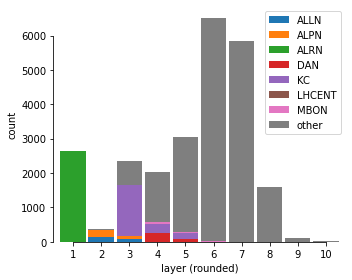

In [87]:
# Group by rounded layer and count
layers['layer_mean_rounded'] = layers.layer_mean.round().astype(int)
w_bins = layers.groupby(['layer_mean_rounded', 'type_broad'], as_index=False).size()
w_bins = w_bins.reset_index(drop=False).pivot(index='layer_mean_rounded', columns='type_broad').fillna(0).loc[:, 'size']

fig, ax = plt.subplots(figsize=(5, 4))

ax = w_bins.plot.bar(stacked=True, width=.9, ax=ax)

ax.set_xlabel('layer (rounded)')
ax.set_ylabel('count')

l = ax.get_legend()
l.set_title('')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

sns.despine(trim=True)
plt.tight_layout()

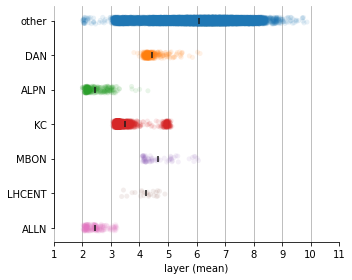

In [93]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

fig, ax = plt.subplots(figsize=(5, 4))

order = layers.type_broad.unique()

ax = sns.stripplot(data=layers, y='type_broad', x='layer_mean', alpha=.1, order=order, ax=ax)

x = layers.groupby('type_broad')['layer_mean'].mean().loc[order]
y = np.arange(0, len(order))

ax.scatter(x, y, marker='|', c='k', zorder=100)

ax.set_xlabel('layer (mean)')
ax.set_ylabel('')

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(np.arange(1, 12))

ax.grid(True, axis='x', which='both')

sns.despine(trim=True)

plt.tight_layout()

In [94]:
# Map pre/post ntype onto edges
edges['ntype_pre'] = edges.bodyId_pre.map(layers.ntype_broad)
edges['ntype_post'] = edges.bodyId_post.map(layers.ntype_broad)

# Map pre/post layer onto edges
edges['layer_pre'] = edges.bodyId_pre.map(layers.layer_mean)
edges['layer_post'] = edges.bodyId_post.map(layers.layer_mean)

edges.head()

,bodyId_pre,bodyId_post,weight,weight_norm_pre,weight_norm_post,ntype_pre,ntype_post,layer_pre,layer_post
5,295115429,326134056,2,0.022222,0.017094,other,other,4.457,4.296
13,295115429,580192148,2,0.022222,0.015038,other,other,4.457,4.416
16,295115429,295132551,2,0.022222,0.007353,other,other,4.457,3.943
20,295115429,294436967,2,0.022222,0.000711,other,DAN,4.457,4.282
23,295115429,295473400,2,0.022222,0.007874,other,other,4.457,5.021


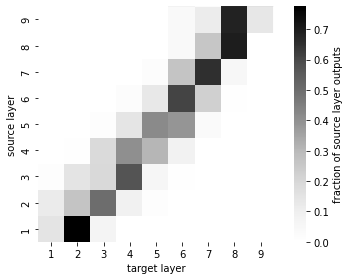

In [95]:
# Round layers for visualization
edges_abs = edges[~edges.layer_pre.isnull() & ~edges.layer_post.isnull()].copy()
edges_abs['layer_post'] = edges_abs.layer_post.round() #.astype(int)
edges_abs['layer_pre'] = edges_abs.layer_pre.round()#.astype(int)

# Get total synapse count between layers
edges_by_layer = edges_abs.groupby(['layer_pre',
                                    'layer_post'], as_index=False).weight.sum()

layers_out_sum = edges_abs.groupby('layer_pre').weight.sum()

# Normalise by source layer
edges_by_layer['weight_norm'] = edges_by_layer.weight / edges_by_layer.layer_pre.map(layers_out_sum)

edges_by_layer_adj = edges_by_layer.pivot(columns='layer_post',
                                          index='layer_pre',
                                          values='weight_norm').fillna(0)

hm = sns.heatmap(edges_by_layer_adj, cmap='Greys', cbar_kws={'label': 'fraction of source layer outputs'}, square=True)

_ = hm.set_xticklabels(range(1, 14), rotation=0)
_ = hm.set_yticklabels(range(1, 14), va='center')

hm.set_xlabel('target layer')
hm.set_ylabel('source layer')

hm.set_ylim(0, 9)
hm.set_xlim(0, 9)

plt.tight_layout()

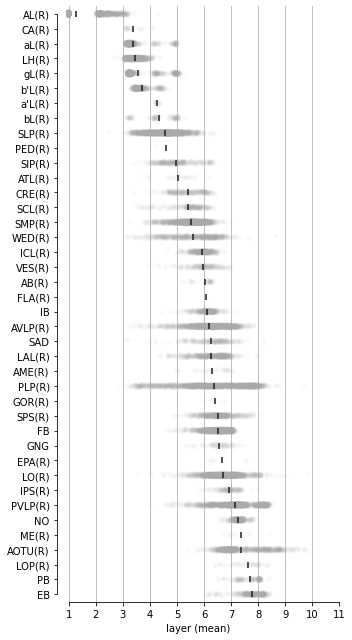

In [97]:
# Determine the main ROI for each neuron, that in which is has the most postsynaptic sites
roi_df = meta.set_index('bodyId').roiInfo.apply(lambda rois: max(rois, key=lambda k: rois[k].get('post', 0)) if len(rois) else None)
layers['main_roi'] = roi_df

# Get neurons for which we have an ROI (except for RNs)
has_roi = ~layers.main_roi.isnull()
not_rn = layers.type_broad != 'RN'
# Mean layer per ROI
by_roi = layers[has_roi & not_rn].groupby('main_roi')['layer_mean'].mean()

# Sort such that the mean layer increases
all_rois = layers[has_roi & not_rn & ~layers.main_roi.str.contains('\(L\)').astype(bool)].main_roi.unique()
roi_order = sorted(all_rois, key=lambda x: by_roi.loc[x])

fig, ax = plt.subplots(figsize=(5, 9))

ax = sns.stripplot(data=layers[has_roi & not_rn],
                   color='darkgrey',
                   order=roi_order,
                   y='main_roi', x='layer_mean', alpha=.05, ax=ax)

x = layers[has_roi & not_rn].groupby('main_roi')['layer_mean'].mean().loc[roi_order]
y = np.arange(0, len(x))

ax.scatter(x, y, marker='|', c='k', zorder=100)

ax.set_xlabel('layer (mean)')
ax.set_ylabel('')

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(np.arange(1, 12))

ax.grid(True, axis='x', which='both')

sns.despine(trim=True)

ax.set_ylim(len(y) - .5, -.5)

plt.tight_layout()